# Phase 3: Final Model Training & Evaluation

## Objective
Train, evaluate, and finalize the Multimodal Logistic Regression model selected in Phase 2.
This pipeline combines text features (TF-IDF) with numerical market features to predict causality.

## Steps
1. Setup & Data Loading
2. Preprocessing
3. Model Training (Multimodal Pipeline)
4. Evaluation
5. Error Analysis
6. Model Saving

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, classification_report
)

# Configuration
DATA_PATH = "Dataset_Final_Financiality_Casuality.csv"
MODEL_SAVE_PATH = "final_multimodal_model.pkl"
SEED = 42

print("Libraries imported successfully.")

Libraries imported successfully.


## 1. Load Dataset
Loading the dataset.

In [2]:
try:
    # Dataset has a header, so we can load it directly
    df = pd.read_csv(DATA_PATH)
    print(f"Dataset loaded. Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: {DATA_PATH} not found.")

# Display first few rows
df.head()

Dataset loaded. Shape: (36672, 8)


,date,ticker,title,clean_text,return_t1,return_t5,volatility_5,causal_label
0,2018-01-24,IRS,Trump to name tax lawyer Rettig to head IRS - ...,"January 24, 2018 / 2:55 AM / Updated 12 minute...",-0.058179,-0.014003,0.038975,1
1,2017-02-10,RM,RM LAW Announces Class Action Lawsuit Against ...,"BERWYN, Pa., Jan. 23, 2018 /PRNewswire/ -- RM ...",0.009906,-0.098405,0.038090,1
2,2017-02-10,RM,RM LAW Announces Class Action Lawsuit Against ...,"BERWYN, Pa., Jan. 23, 2018 /PRNewswire/ -- RM ...",0.009906,-0.098405,0.038090,1
3,2017-02-10,RM,RM LAW Announces Class Action Lawsuit Against ...,"BERWYN, Pa., Jan. 23, 2018 /PRNewswire/ -- RM ...",0.009906,-0.098405,0.038090,1
4,2017-02-10,RM,RM LAW Announces Class Action Lawsuit Against ...,"BERWYN, Pa., Jan. 23, 2018 /PRNewswire/ -- RM ...",0.009906,-0.098405,0.038090,1


In [3]:
# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Check for missing values
print("Missing values:\n", df.isnull().sum())

Missing values:
 date            0
ticker          0
title           0
clean_text      0
return_t1       0
return_t5       0
volatility_5    0
causal_label    0
dtype: int64


## 2. Train/Test Split
Using a time-based split to simulate real-world forecasting and avoid data leakage.

In [4]:
# Time-based split (80/20)
df.sort_values("date", inplace=True)
split_idx = int(len(df) * 0.8)

train_df = df.iloc[:split_idx].copy()
test_df = df.iloc[split_idx:].copy()

print(f"Train set: {train_df.shape}")
print(f"Test set: {test_df.shape}")

# Define features
text_feature = "clean_text"
num_features = ["return_t1", "return_t5", "volatility_5"]
target = "causal_label"

X_train = train_df[[text_feature] + num_features]
y_train = train_df[target]

X_test = test_df[[text_feature] + num_features]
y_test = test_df[target]

Train set: (29337, 8)
Test set: (7335, 8)


## 3. Multimodal Pipeline Construction
Re-implementing the Phase 2 best model:
- **Text**: TF-IDF (20k features, ngram 1-2)
- **Numeric**: StandardScaler
- **Model**: Logistic Regression (Balanced class weight)

In [5]:
preprocessor = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(
            max_features=20000,
            ngram_range=(1, 2),
            stop_words="english"
        ), text_feature),
        ("num", StandardScaler(), num_features)
    ]
)

model_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=SEED))
])

print("Pipeline constructed.")

Pipeline constructed.


## 4. Training

In [6]:
print("Training model...")
model_pipeline.fit(X_train, y_train)
print("Training complete.")

Training model...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: divide by zero encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: overflow encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: invalid value encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)


Training complete.


## 5. Evaluation

In [7]:
y_pred = model_pipeline.predict(X_test)
y_prob = model_pipeline.predict_proba(X_test)[:, 1]

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("--- Evaluation Results ---")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

--- Evaluation Results ---
Accuracy:  0.7736
Precision: 0.9113
Recall:    0.7397
F1 Score:  0.8166

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.85      0.70      2337
           1       0.91      0.74      0.82      4998

    accuracy                           0.77      7335
   macro avg       0.76      0.79      0.76      7335
weighted avg       0.81      0.77      0.78      7335



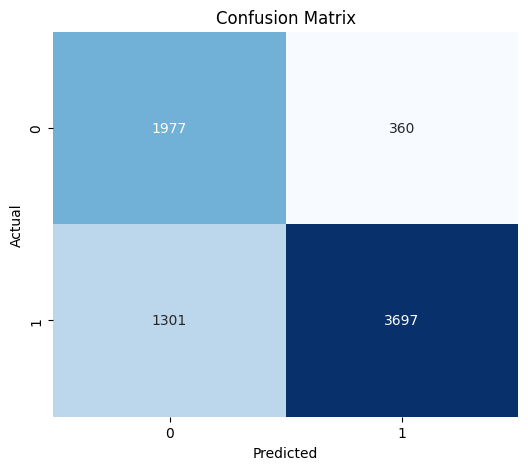

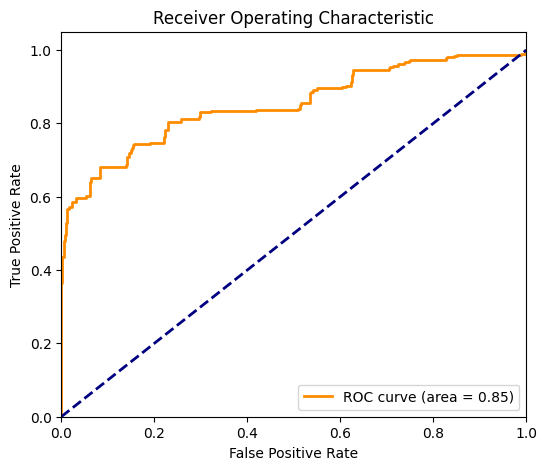

In [8]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

def plot_roc_curve(y_true, y_prob):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

plot_confusion_matrix(y_test, y_pred)
plot_roc_curve(y_test, y_prob)

## 6. Interpretation: Top Features
Analyzing the most influential words and features.

In [9]:
# Extract feature names
tfidf_feature_names = model_pipeline.named_steps['preprocessor'].named_transformers_['text'].get_feature_names_out()
all_feature_names = np.concatenate([tfidf_feature_names, num_features])

# Coefficients
coeffs = model_pipeline.named_steps['clf'].coef_[0]

# Top positive (causal) and negative (non-causal) features
top_n = 20
sorted_idx = np.argsort(coeffs)
top_pos_idx = sorted_idx[-top_n:][::-1]
top_neg_idx = sorted_idx[:top_n]

print("Top Positive (Causal) Features:")
for idx in top_pos_idx:
    print(f"{all_feature_names[idx]}: {coeffs[idx]:.4f}")

print("\nTop Negative (Non-Causal) Features:")
for idx in top_neg_idx:
    print(f"{all_feature_names[idx]}: {coeffs[idx]:.4f}")

Top Positive (Causal) Features:
volatility_5: 7.3409
bb: 2.8514
rwe: 2.7343
hagens berman: 2.6744
hagens: 2.6744
ge: 2.5673
agnc: 2.5457
berman: 2.5331
bp: 2.5326
vici: 2.4281
intel: 2.3627
innogy: 2.3358
gpi: 2.2184
iag: 2.1645
talkspace: 2.1332
poet: 2.1075
cvs: 2.0942
stock: 2.0925
alliance: 2.0780
solid biosciences: 1.9611

Top Negative (Non-Causal) Features:
wageworks: -4.4851
bhp: -2.8949
indexes: -2.6229
libor: -2.5826
transwestern: -2.5354
ulta: -2.4130
gm: -2.2144
motif bio: -2.1313
00: -2.0658
envision: -2.0552
battery: -2.0288
kobe: -1.9561
motif: -1.9380
jay: -1.9318
wynn: -1.9291
pr: -1.9224
advantmed: -1.9063
irs: -1.8713
core mark: -1.8318
edf: -1.8184


### Feature Importance Plot

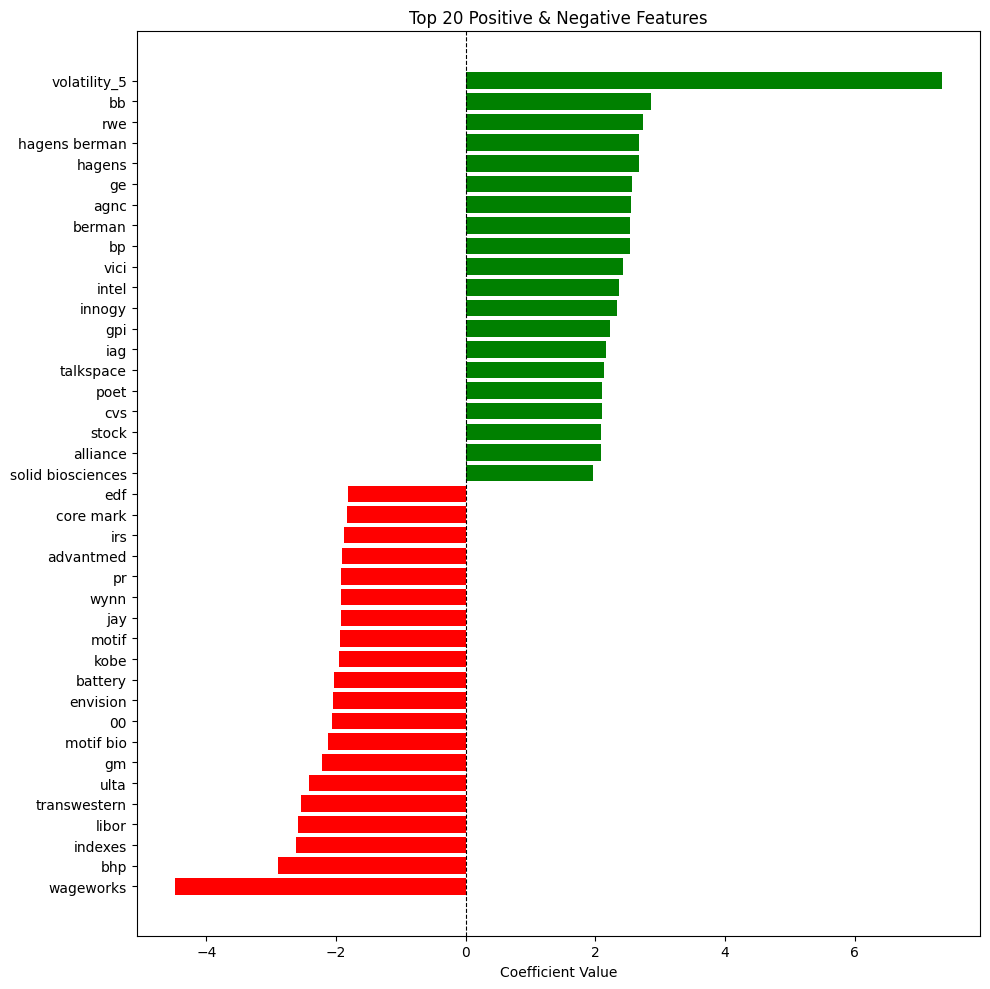

In [10]:
def plot_feature_importance(coeffs, feature_names, top_n=20):
    # Sort indices
    sorted_idx = np.argsort(coeffs)
    top_pos_idx = sorted_idx[-top_n:]
    top_neg_idx = sorted_idx[:top_n]
    
    # Combine
    idx_to_plot = np.concatenate([top_neg_idx, top_pos_idx])
    cols_to_plot = [feature_names[i] for i in idx_to_plot]
    coeffs_to_plot = coeffs[idx_to_plot]
    
    # Color mapping: Green for positive, Red for negative
    colors = ['red' if c < 0 else 'green' for c in coeffs_to_plot]
    
    plt.figure(figsize=(10, 10))
    plt.barh(cols_to_plot, coeffs_to_plot, color=colors)
    plt.xlabel("Coefficient Value")
    plt.title(f"Top {top_n} Positive & Negative Features")
    plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
    plt.tight_layout()
    plt.show()

plot_feature_importance(coeffs, all_feature_names)

### Precision-Recall Curve

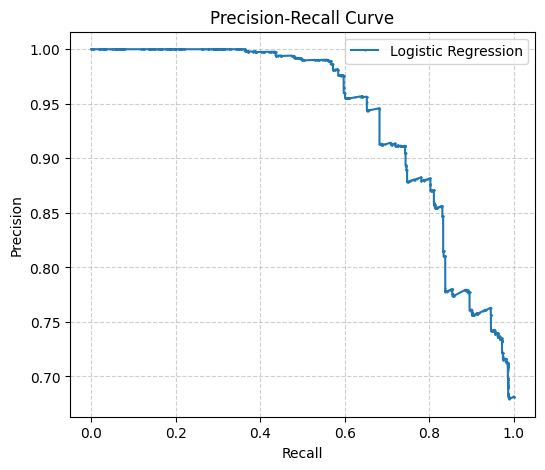

In [11]:
from sklearn.metrics import precision_recall_curve

def plot_pr_curve(y_true, y_prob):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    
    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, marker='.', markersize=1, label='Logistic Regression')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

plot_pr_curve(y_test, y_prob)

### Prediction Confidence Distribution

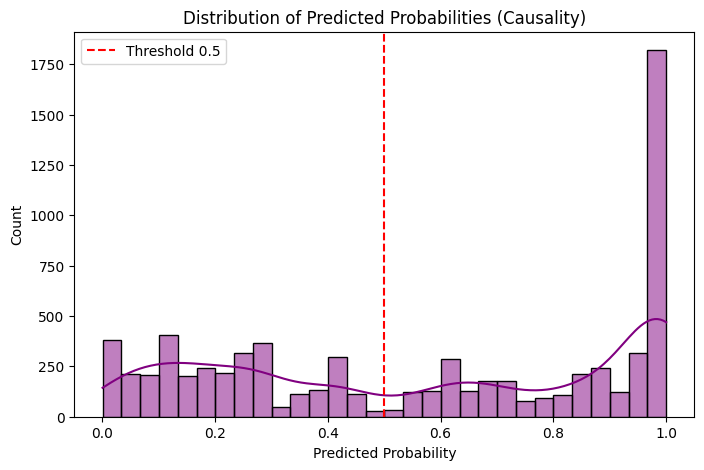

In [12]:
plt.figure(figsize=(8, 5))
sns.histplot(y_prob, bins=30, kde=True, color='purple')
plt.title('Distribution of Predicted Probabilities (Causality)')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.axvline(0.5, color='red', linestyle='--', label='Threshold 0.5')
plt.legend()
plt.show()

## 7. Save Model

In [13]:
joblib.dump(model_pipeline, MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")

Model saved to final_multimodal_model.pkl
